In [1]:
import pandas as pd
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import time

import matplotlib
import lightgbm as lgb
from sklearn.model_selection import KFold
import gc

from skopt.space import Real, Integer
from skopt.utils import use_named_args
import itertools
from sklearn.metrics import mean_squared_error
from skopt import gp_minimize

In [8]:
X_train = pd.read_csv('C:/Users/1/Python/Kaggle/Elo loyalty card/train_clean.csv', nrows = 10000)
test = pd.read_csv('C:/Users/1/Python/Kaggle/Elo loyalty card/test_clean.csv', nrows = 10000)

target = train['target']

In [3]:
# create training and testing vars
#X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2)

In [28]:
X_train['outliers'] = 0
X_train.loc[X_train['target'] < -30, 'outliers'] = 1
X_train = X_train[X_train['outliers'] == 0]
target = X_train['target']

C:\Users\1\Anaconda2\envs\Python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\1\Anaconda2\envs\Python\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [4]:
categorical = ['feature_1', 'feature_2', 'feature_3', 'installments', 'city_id', 'category_2']
objects = ['first_active_month','card_id','outliers', 'target']
features = [c for c in X_train.columns if c not in objects]

In [5]:
# from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(3, 10, name='max_depth'),
          Integer(30, 100, name='num_leaves'),
          Integer(50, 200, name='min_data_in_leaf'),
          Real(0.5, 0.9,  name='feature_fraction'),
          Real(0.5, 0.9,  name='bagging_fraction'),
          Integer(1, 100, name='lambda_l1'),
          Integer(1, 5, name='bagging_freq'),
         ]

In [9]:
def objective(values):

    param = {'max_depth': values[0],
              'num_leaves': values[1],
              'min_data_in_leaf': values[2],
              "feature_fraction": values[3],
             "bagging_fraction": values[4],
              "lambda_l1": values[5],
              "bagging_freq": values[6],
              'min_data':1,
             'min_data_in_bin':1,
              "min_child_samples": 20,
              'objective':'regression',
              'learning_rate': 0.1,
              "boosting": "gbdt",
              "bagging_seed": 2018,
              "metric": 'rmse',
              "random_state": 4590}

    print('\nNext set of params.....',param)
    
    folds = KFold(n_splits=2, shuffle=True, random_state=15)
    oof = np.zeros(len(X_train))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])#, categorical_feature=categorical)
        val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])#, categorical_feature=categorical)

        num_round = 5000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    return np.sqrt(mean_squared_error(oof, target))

In [10]:
res_gp = gp_minimize(objective, space, n_calls=10,
                     random_state=0,n_random_starts=10)

"Best score=%.4f" % res_gp.fun


Next set of params..... {'max_depth': 7, 'num_leaves': 89, 'min_data_in_leaf': 179, 'feature_fraction': 0.8389006955136502, 'bagging_fraction': 0.749425478714389, 'lambda_l1': 39, 'bagging_freq': 2, 'min_data': 1, 'min_data_in_bin': 1, 'min_child_samples': 20, 'objective': 'regression', 'learning_rate': 0.1, 'boosting': 'gbdt', 'bagging_seed': 2018, 'metric': 'rmse', 'random_state': 4590}
fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.24408	valid_1's rmse: 3.61196
[200]	training's rmse: 2.96532	valid_1's rmse: 3.64902
Early stopping, best iteration is:
[61]	training's rmse: 3.37843	valid_1's rmse: 3.5934
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.18662	valid_1's rmse: 3.66764
[200]	training's rmse: 2.93284	valid_1's rmse: 3.69314
Early stopping, best iteration is:
[36]	training's rmse: 3.41896	valid_1's rmse: 3.6438

Next set of params..... {'max_depth': 3, 'num_leaves': 49, 'min_da

[100]	training's rmse: 3.20308	valid_1's rmse: 3.6682
[200]	training's rmse: 2.95558	valid_1's rmse: 3.70252
Early stopping, best iteration is:
[42]	training's rmse: 3.40412	valid_1's rmse: 3.64424

Next set of params..... {'max_depth': 8, 'num_leaves': 96, 'min_data_in_leaf': 149, 'feature_fraction': 0.505428654244844, 'bagging_fraction': 0.7491384382186679, 'lambda_l1': 68, 'bagging_freq': 5, 'min_data': 1, 'min_data_in_bin': 1, 'min_child_samples': 20, 'objective': 'regression', 'learning_rate': 0.1, 'boosting': 'gbdt', 'bagging_seed': 2018, 'metric': 'rmse', 'random_state': 4590}
fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.27797	valid_1's rmse: 3.60638
[200]	training's rmse: 3.00912	valid_1's rmse: 3.63038
Early stopping, best iteration is:
[49]	training's rmse: 3.43244	valid_1's rmse: 3.58173
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.21987	valid_1's rmse: 3.66954
[200]	train

'Best score=3.6115'

In [42]:
print("""Best parameters:
- max_depth=%d
- num_leaves=%d
- min_data_in_leaf=%d
- feature_fraction=%.4f
- bagging_fraction=%.4f
- lambda_l1=%.4f
- bagging_freq=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4],res_gp.x[5],res_gp.x[6]))

Best parameters:
- max_depth=8
- num_leaves=96
- min_data_in_leaf=149
- feature_fraction=0.5054
- bagging_fraction=0.7491
- lambda_l1=68.0000
- bagging_freq=5


In [43]:
param = {'max_depth': res_gp.x[0],
              'num_leaves': res_gp.x[1],
              'min_data_in_leaf': res_gp.x[2],
              "feature_fraction": res_gp.x[3],
             "bagging_fraction": res_gp.x[4],
              "lambda_l1": res_gp.x[5],
              "bagging_freq": res_gp.x[6],
              "min_child_samples": 20,
              'objective':'regression',
              'learning_rate': 0.1,
              "boosting": "gbdt",
              "bagging_seed": 2018,
              "metric": 'rmse',
              "random_state": 4590}

In [44]:
param = {'max_depth': res_gp.x[0],
              'num_leaves': res_gp.x[1],
              'min_data_in_leaf': res_gp.x[2],
              "feature_fraction": res_gp.x[3],
             "bagging_fraction": res_gp.x[4],
              "lambda_l1": res_gp.x[5],
              "bagging_freq": res_gp.x[6],
              "min_child_samples": 20,
              'objective':'regression',
              'learning_rate': 0.1,
              "boosting": "gbdt",
              "bagging_seed": 2018,
              "metric": 'rmse',
              "random_state": 4590}
    
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])#, categorical_feature=categorical)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])#, categorical_feature=categorical)

    num_round = 5000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
print("CV score on test: {:<8.5f}".format(mean_squared_error(predictions, y_test)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.64489	valid_1's rmse: 1.90203
[200]	training's rmse: 1.59119	valid_1's rmse: 1.90539
Early stopping, best iteration is:
[5]	training's rmse: 1.72134	valid_1's rmse: 1.88768
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.68183	valid_1's rmse: 1.73817
[200]	training's rmse: 1.62044	valid_1's rmse: 1.74691
Early stopping, best iteration is:
[1]	training's rmse: 1.76822	valid_1's rmse: 1.72749
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.66966	valid_1's rmse: 1.7956
[200]	training's rmse: 1.61191	valid_1's rmse: 1.79465
Early stopping, best iteration is:
[1]	training's rmse: 1.7533	valid_1's rmse: 1.7869
fold n°3
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.68628	valid_1's rmse: 1.71251
[200]	training's rmse: 1.62752	valid_1's rmse: 1.7244
Early stoppi

C:\Users\1\Anaconda2\envs\Python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


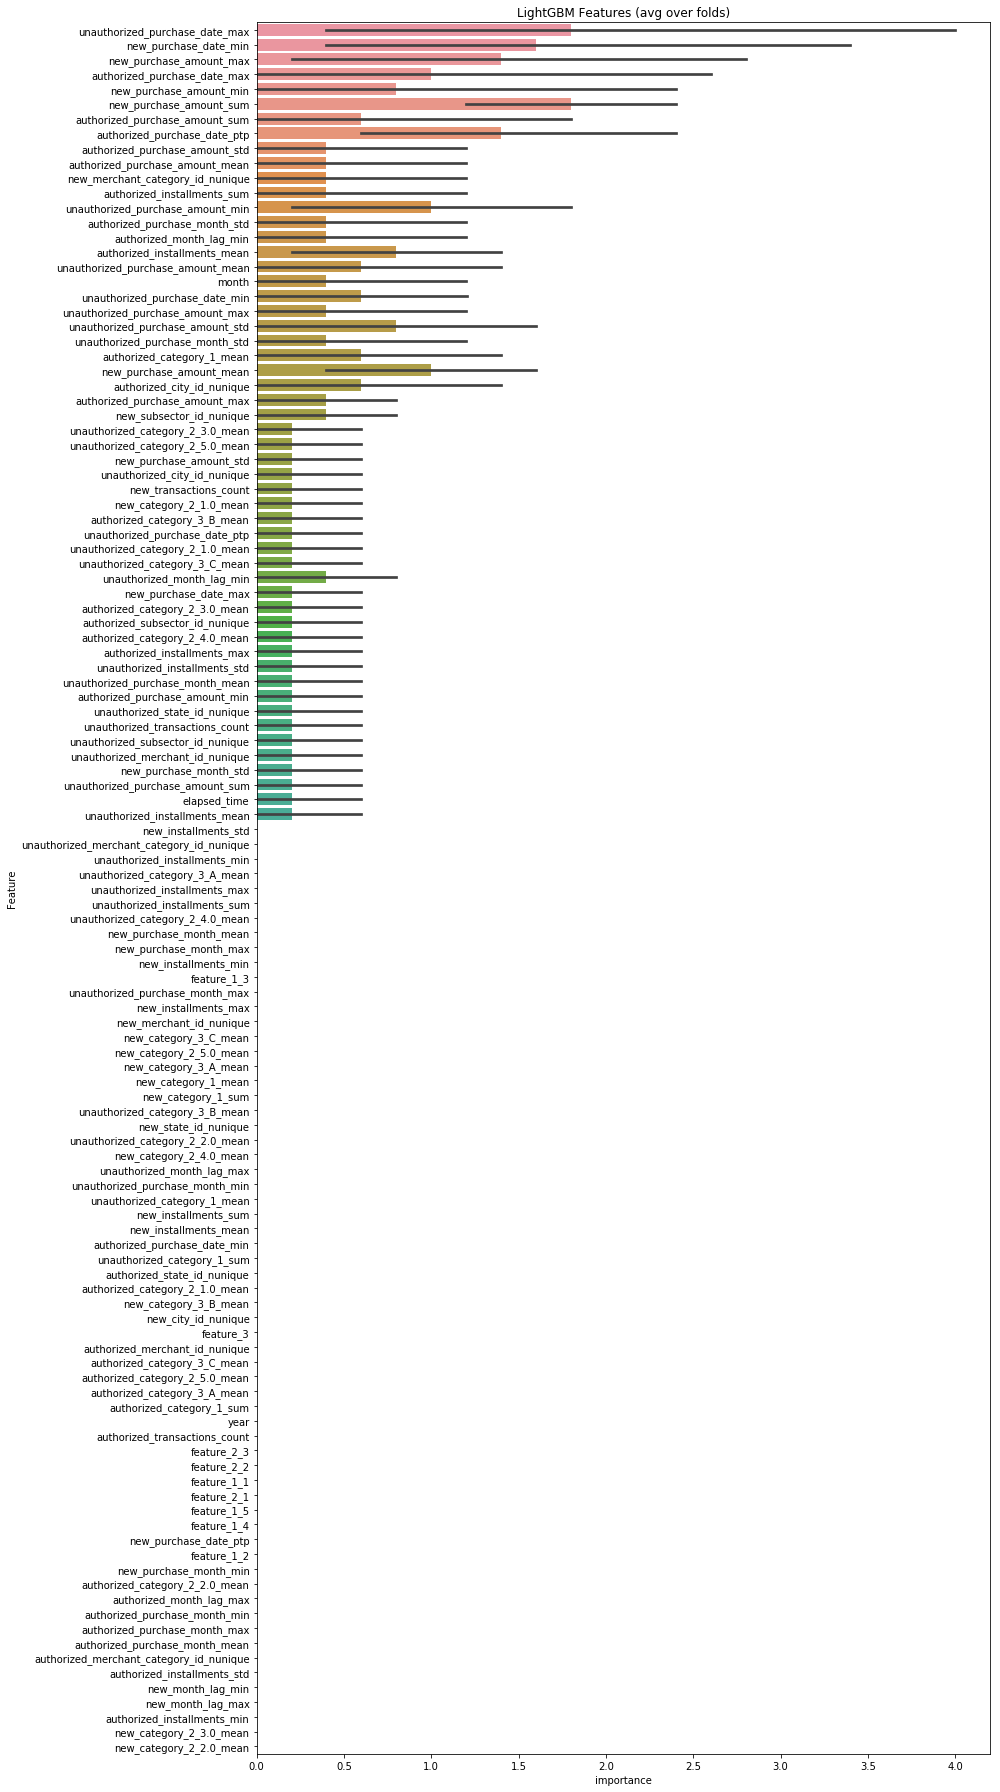

In [47]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()